# Hidden Markov Model for NER


In [1]:
from app.travel_resolver.libs.nlp.data_processing import from_bio_file_to_examples

BIO_FILE = "data/bio/fr.bio/1k_samples.bio"

sentences, labels, _, unique_labels = from_bio_file_to_examples(BIO_FILE)

[nltk_data] Downloading package punkt_tab to /Users/az-r-
[nltk_data]     ow/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
from app.travel_resolver.libs.nlp.data_processing import process_sentence

processed_sentences = []
processed_labels = []

for sentence, label in zip(sentences, labels):
    p_sentence, p_label = process_sentence(
        sentence, stemming=True, labels_to_adapt=label
    )
    processed_sentences.append(p_sentence)
    processed_labels.append(p_label)

Splitting the data between **training** and **test** set. We will do an `80/20` split.


In [3]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, y_train, y_test = train_test_split(
    processed_sentences, processed_labels, test_size=0.2
)

In [4]:
def t2_given_t1(
    t2: str | int,
    t1: str | int,
    train_bag=y_train,
    unique_labels_mapping: dict = unique_labels,
):
    """
    Get the probability of getting t2 given t1 in the given labels

    Args:
      t2: str | int, the second tag
      t1: str | int, the first tag
      train_bag: list, the list of labels

    Returns:
      float, the probability of getting t2 given t1
    """
    t1 = t1 if isinstance(t1, int) else unique_labels_mapping[t1]
    t2 = t2 if isinstance(t2, int) else unique_labels_mapping[t2]
    count_t1 = 0
    count_t2_t1 = 0
    for row in train_bag:
        for index in range(len(row) - 1):
            if row[index] == t1:
                count_t1 += 1
            if row[index] == t1 and row[index + 1] == t2:
                count_t2_t1 += 1
    return count_t2_t1 / count_t1

In the next part, we will be getting the **transition matrix** which represents the _probability_ of transitioning from a state to another $P(S_2 | S_1)$. In our case it would be for example $P(O | \text{ARR-LOC})$.


In [5]:
import numpy as np

tags = list(unique_labels.keys())
n_tags = len(tags)

trans_matrix = np.zeros((n_tags, n_tags))

for t1 in range(n_tags):
    for t2 in range(n_tags):
        trans_matrix[t1][t2] = t2_given_t1(tags[t1], tags[t2])

trans_matrix

array([[0.7401981 , 0.90635838, 0.54849885],
       [0.09760627, 0.06358382, 0.3891455 ],
       [0.16219563, 0.0300578 , 0.06235566]])

In [6]:
import pandas as pd

trans_matrix_df = pd.DataFrame(trans_matrix, columns=tags, index=tags)

trans_matrix_df

,O,LOC-ARR,LOC-DEP
O,0.740198,0.906358,0.548499
LOC-ARR,0.097606,0.063584,0.389145
LOC-DEP,0.162196,0.030058,0.062356


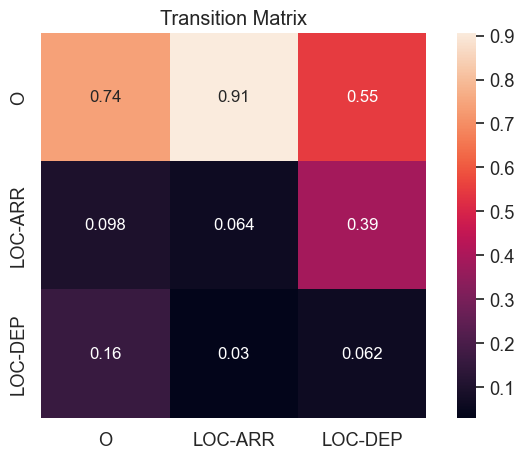

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.set(font_scale=1.2)

sns.heatmap(trans_matrix_df, annot=True, square=True, annot_kws={"fontsize": 12})

plt.title("Transition Matrix")

plt.show()

In [8]:
import math
from fractions import Fraction


def round_down(x, a):
    return math.floor(x / a) * a


def get_emission_prob_dict(
    sentences: list[str] = train_sentences,
    labels: list[int] = y_train,
    tags: dict = unique_labels,
):
    """
    Given a bunch of sentences and their labels, get the emission probability of each word given each tag

    Parameters:
    sentences (list): The list of sentences
    labels (list): The list of labels
    tags (dict): The dictionary of tags

    Returns:
    dict: The dictionary of emission probabilities
    """
    tags = list(tags.keys())
    word_tag_count = {}
    # Add <UNK> tag
    word_tag_count["<UNK>"] = {tag: 0 for tag in tags}

    tag_count = {tag: 0 for tag in tags}

    # Count n times a word has tag
    for i in range(len(sentences)):
        for word, label in zip(sentences[i].split(" "), labels[i]):
            if word not in word_tag_count:
                word_tag_count[word] = {tag: 0 for tag in tags}
            word_tag_count[word][tags[label]] += 1
            tag_count[tags[label]] += 1

    words_to_remove = []

    # combining least represented words under <UNK>
    for word in word_tag_count:
        # if word not frequent enough add it to <UNK>
        if sum(word_tag_count[word].values()) < 3 and not word == "<UNK>":
            for tag in word_tag_count[word]:
                word_tag_count["<UNK>"][tag] += word_tag_count[word][tag]
            words_to_remove.append(word)
            continue

    word_tag_count = {
        key: word_tag_count[key] for key in word_tag_count if key not in words_to_remove
    }

    # Calculate the prob of a word given tag
    for word in word_tag_count:
        if word == "<UNK>":
            print(word_tag_count[word])
        for tag in word_tag_count[word]:
            if word_tag_count[word][tag] == 0:
                word_tag_count[word][tag] = 0
                continue
            word_tag_count[word][tag] = word_tag_count[word][tag] / tag_count[tag]

    return word_tag_count

In [9]:
em_prob_dict = get_emission_prob_dict()

em_prob_df = pd.DataFrame(em_prob_dict).T

em_prob_df.head(10)

{'O': 8, 'LOC-ARR': 682, 'LOC-DEP': 678}


,O,LOC-ARR,LOC-DEP
<UNK>,0.001417,0.788439,0.78291
je,0.081134,0.000000,0.00000
dois,0.011515,0.000000,0.00000
trouv,0.041807,0.000000,0.00000
moyen,0.011337,0.000000,0.00000
transport,0.021789,0.000000,0.00000
aller,0.046767,0.000000,0.00000
utilis,0.015766,0.000000,0.00000
servic,0.007440,0.000000,0.00000
public,0.003012,0.000000,0.00000


In [10]:
em_prob = em_prob_df.to_numpy()

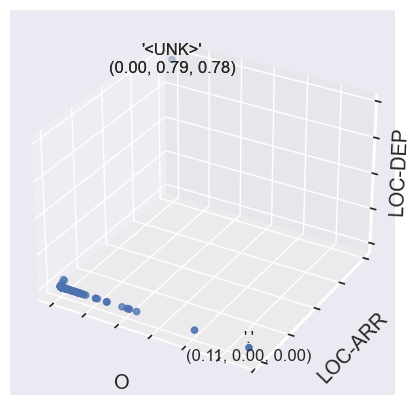

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")

xx = em_prob[:, 0]
yy = em_prob[:, 1]
zz = em_prob[:, 2]

xlabel = list(em_prob_df.columns)[0]
ylabel = list(em_prob_df.columns)[1]
zlabel = list(em_prob_df.columns)[2]

# Words with the highest probability on each axis
x_highest_i = np.argmax(em_prob[:, 0])
y_highest_i = np.argmax(em_prob[:, 1])
z_highest_i = np.argmax(em_prob[:, 2])

for i in enumerate([x_highest_i, y_highest_i, z_highest_i]):
    ax.text(
        xx[i[1]],
        yy[i[1]],
        zz[i[1]],
        f"'{em_prob_df.index[i[1]]}'\n({xx[i[1]]:.2f}, {yy[i[1]]:.2f}, {zz[i[1]]:.2f})",
        fontsize=12,
        ha="center",
        va="center",
    )

ax.scatter(xx, yy, zz)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.get_zaxis().set_ticklabels([])

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)

# Move zlabel closer to plot
ax.zaxis.labelpad = -10

plt.show()

In [12]:
def get_start_prob(labels: list[int] = y_train, tags: dict = unique_labels):
    """
    Get the start probability of each tag

    Parameters:
    labels (list): The list of labels
    tags (dict): The dictionary of tags

    Returns:
    dict: The dictionary of start probabilities
    """
    tags = list(tags.keys())
    start_prob = {tag: 0 for tag in tags}
    for label in labels:
        start_prob[tags[label[0]]] += 1
    total_count = sum(start_prob.values())
    for tag in start_prob:
        start_prob[tag] /= total_count
    return start_prob

In [13]:
startprob = get_start_prob()

startprob = np.array(list(startprob.values()))

startprob

array([1., 0., 0.])

Since we already have the model parameters, we don't need to use the automatic model estimation with `fit()`. Therefore, we will pass the probabilities directly to the model and move on to the predictions.


In [14]:
from hmmlearn.hmm import CategoricalHMM

vocab = list(em_prob_dict.keys())

hmm = CategoricalHMM(n_components=n_tags, n_iter=100)

hmm.n_features = len(vocab)
hmm.startprob_ = startprob
hmm.transmat_ = trans_matrix.T
hmm.emissionprob_ = em_prob.T

In [15]:
def encode_sentence(sentence: str, vocab: list[str]):
    """
    Encode a sentence into a list of integers

    Parameters:
    sentence (str): The sentence to encode
    vocab (list): The vocabulary

    Returns:
    list: The list of integers
    """
    return [
        vocab.index(word) if word in vocab else vocab.index("<UNK>")
        for word in sentence.split(" ")
    ]

In [16]:
from app.travel_resolver.libs.nlp.data_processing import process_sentence

vocab = list(em_prob_dict.keys())

test_sentence = "Quel trajet faire pour aller de Perpignan a Montpellier"

test_sentence = process_sentence(test_sentence, stemming=True)

test_sentence_encoded = encode_sentence(test_sentence, vocab)

test_sentence_encoded = np.array(test_sentence_encoded).reshape(-1, 1)

predicted_labels = hmm.predict(test_sentence_encoded)

for word, label in zip(test_sentence.split(" "), predicted_labels):
    print(f"{word}: {list(unique_labels.keys())[label]}")

quel: O
trajet: O
fair: O
aller: O
perpignan: LOC-DEP
a: LOC-ARR
montpelli: LOC-ARR


In [17]:
test_sentences_encoded = [
    encode_sentence(sentence, vocab) for sentence in test_sentences
]
test_sentences_lengths = [len(sentence) for sentence in test_sentences_encoded]


test_sentences_encoded_flat = [
    item for sublist in test_sentences_encoded for item in sublist
]
test_sentences_encoded = np.array(test_sentences_encoded_flat).reshape(-1, 1)

predicted_labels_test = hmm.predict(test_sentences_encoded, test_sentences_lengths)

In [18]:
from sklearn.metrics import accuracy_score, f1_score

y_test = [item for sublist in y_test for item in sublist]

accuracy = accuracy_score(y_test, predicted_labels_test)
f1 = f1_score(y_test, predicted_labels_test, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.9225771521386031
F1 Score: 0.9197892032803431


Text(0.5, 1.0, 'Confusion Matrix')

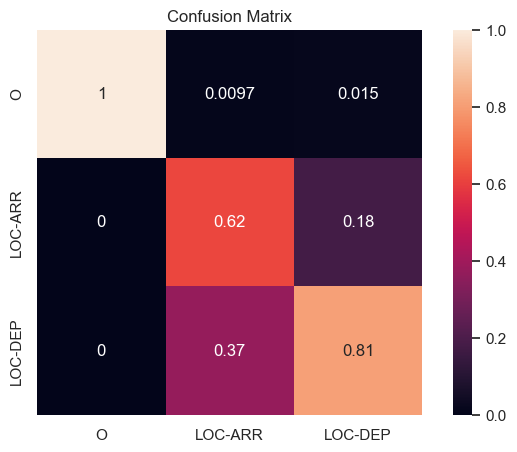

In [68]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predicted_labels_test)

conf_matrix = conf_matrix / conf_matrix.sum(axis=0)

conf_matrix_df = pd.DataFrame(conf_matrix, columns=tags, index=tags)


plt.figure(figsize=(8, 5))

sns.set(font_scale=1)

sns.heatmap(conf_matrix_df, annot=True, square=True, annot_kws={"fontsize": 12})

plt.title("Confusion Matrix")

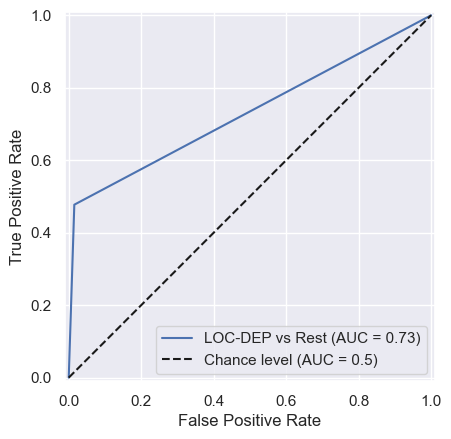

In [20]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

class_of_interest = "LOC-DEP"
class_id = list(unique_labels.keys()).index(class_of_interest)

label_binarizer = LabelBinarizer().fit(y_test)
y_test_onehot = label_binarizer.transform(y_test)
y_pred_onehot = label_binarizer.transform(predicted_labels_test)

display = RocCurveDisplay.from_predictions(
    y_test_onehot[:, class_id],
    y_pred_onehot[:, class_id],
    name=f"{class_of_interest} vs Rest",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

## Evaluating new sentences

In this section, we will be evaluating the model capacity on sentences that hasn't contributed to the model's probabilities.

The corpus is formed from an initial dataset of 20 unique blueprint sentences that were used to generate a 1000 sentences with different "Departures" and "Arrivals".


In [ ]:
new_sentences, new_labels, new_vocab, new_unique_labels = from_bio_file_to_examples(
    "./data/bio/fr.bio/1k_new_samples.bio"
)

In [ ]:
sls_new_sentences = []
sls_new_labels = []

for sentence, label in zip(new_sentences, new_labels):
    p_sentence, p_label = process_sentence(
        sentence, stemming=True, labels_to_adapt=label
    )
    sls_new_sentences.append(p_sentence)
    sls_new_labels.append(p_label)

In [53]:
sls_new_sentences_encoded = [
    encode_sentence(sentence, vocab) for sentence in sls_new_sentences
]

sls_new_sentences_length = [len(sentence) for sentence in sls_new_sentences_encoded]


sls_new_sentences_flat = [
    item for sublist in sls_new_sentences_encoded for item in sublist
]

sls_new_sentences_encoded = np.array(sls_new_sentences_flat).reshape(-1, 1)

new_sentences_pred = hmm.predict(sls_new_sentences_encoded, sls_new_sentences_length)

In [ ]:
y_real = [item for sublist in sls_new_labels for item in sublist]

In [57]:
accuracy_score_new = accuracy_score(y_real, new_sentences_pred)

print(f"Accuracy: {accuracy_score_new}")

Accuracy: 0.6741152157065358


We can see the sharp decrease from the other corpus, and that's the limitation of HMM, they can go as far as their they know - by know I the known observations and emission probs - .


In [62]:
consufion_matrix_new = confusion_matrix(y_real, new_sentences_pred)

consufion_matrix_new

array([[4173,  728,  797],
       [   1,  572,  385],
       [   1,  611,  474]])

[5698  958 1086]


Text(0.5, 1.0, 'Confusion Matrix')

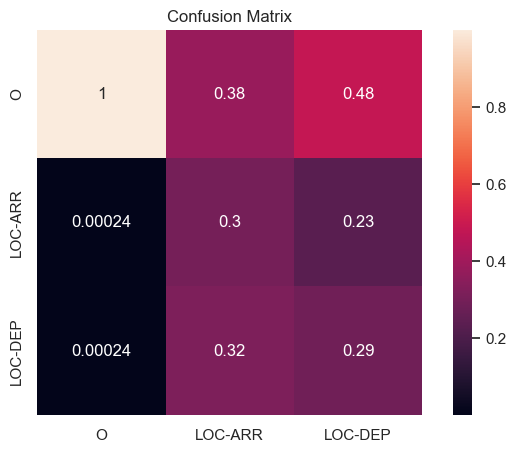

In [67]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_real, new_sentences_pred)

print(conf_matrix.sum(axis=1))

conf_matrix = conf_matrix / conf_matrix.sum(axis=0)

conf_matrix_df = pd.DataFrame(conf_matrix, columns=tags, index=tags)


plt.figure(figsize=(8, 5))

sns.set(font_scale=1)

sns.heatmap(conf_matrix_df, annot=True, square=True, annot_kws={"fontsize": 12})

plt.title("Confusion Matrix")